# Exercise 1: Basic data simulation and reconstruction by FBP

##### Author/contact: Jakob Jorgensen, University of Manchester, UK, jakob.jorgensen@manchester.ac.uk

The goals of this exercise are to get familiar with simulation of sinogram data, tomographic reconstruction using the filtered back-projection (FBP) algorithm as well as basic usage of the ASTRA Tomography Toolbox.

**In this notebook do the following:**

1. Step through the cells below (Shift+Enter), read the descriptions and inspect the generated figures.
2. Try both CPU and GPU versions by changing the variables `proj_type` and `rec_type`; compare run times. Note that normally the first run on the GPU is slow due to initialization.
3. Try increasing the noise level by reducing the value of `flux`. Can other filter types help improve the reconstruction? Try also `filter_type = ’none’` to see the unfiltered back-projection.
4. Play with the parameters `num angles`, `num_detector_pixels` and `rel_detector_size` and try to predict and explain the outcomes.

First we load the required modules. 
We also enable "notebook mode" to allow easily zooming in figures etc.

In [1]:
import numpy as np
import astra
import scipy.io
import matplotlib.pyplot as plt

%matplotlib notebook

To use the GPU-version of the code below, you should automatically be assigned one of the available GPUs (each of the two servers learnmore1 and learnmore2 has two GPUs available, called "0" and "1". Since during the exercises we are many simultaneous users you may experience the code below failing because no GPU was available. If this happens you can try uncommenting the following code line to explicitly specify either to use GPU 0 or 1. You can also try to switch from learnmore1 to learnmore2 or opposite.

We can check the current status of the GPU's on the server you are currently using. Select whichever GPU seems the least used in terms of memory and/or utilization.

In [2]:
!gpustat

learnmore1  Sat Feb 23 16:39:22 2019
[0] Tesla M4         | 25'C,   0 % |     0 /  3785 MB |
[1] Tesla M4         | 23'C,  96 % |     0 /  3785 MB |


In [3]:
astra.astra.set_gpu_index(1)   # 0 or 1

We first load and display a test image to be used for simulating data and reconstruction. We use the so-called Shepp-Logan test image, here of size 512x512 pixels. It is a simple model of a cross section through the human head and commonly used as a tomography test image.

<IPython.core.display.Javascript object>


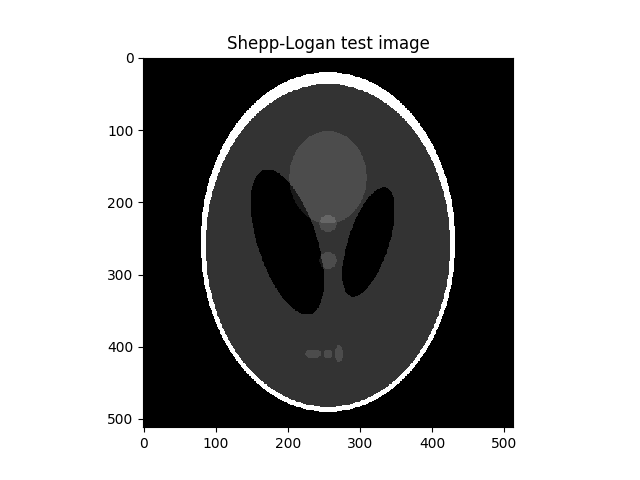

In [4]:
N = 512;
X0 = scipy.io.loadmat('phantom512.mat')['X']
fig = plt.figure(1)
plt.imshow(X0)
plt.title('Shepp-Logan test image')
plt.gray()

The following parameters specify the tomographic imaging setup:

In [5]:
# Number of projection angles.
num_angles = 1024

# Number of detector pixels
num_detector_pixels = 512

# Size of a detector pixel relative to an object pixel. 
# Using 1 specifies they are of same size. 
# Using e.g. 0.5 means a detector pixel is half the size of an object pixel.
rel_detector_size = 1.0

# Incident X-ray flux in photons per time unit. Lower=noisier.
flux = 1e3

We use the specified number of projection angles equally-spaced over 0 to 180 degrees, which is sufficient in parallel-beam, and set up an array with the angles in radians, which is what ASTRA expects:

In [6]:
angles = np.linspace(0,np.pi,num_angles,False)

We want to simulate sinogram data from the test image. To do that using ASTRA we need to set up three things. First a "volume geometry" to represent the size of object/volume, in our case a 512x512 image:

In [7]:
# vol_geom = astra.create_vol_geom(row_count, col_count)
#  Create a 2D volume geometry.  See the API for more information.
#  row_count: number of rows.
#  col_count: number of columns.
#  vol_geom: Python dict containing all information of the volumen geometry.

vol_geom = astra.create_vol_geom(N,N)

Second, we need a "projection geometry" which represents the type of measurement geometry we are using (parallelbeam, fan-beam, cone-beam, etc.). We set up a parallel-beam projection geometry:

In [8]:
# proj_geom = astra.create_proj_geom('parallel',detector_spacing, det_count, angles)
#  Create a projection geometry.
#  detector_spacing: Distance between two adjacent detector pixels (float)
#  det_count: Number of detector pixels (int)
#  angles: Array of angles in radians. (numpy.ndarray)
#  proj_geom: Python dict containing all information of the parallel projection geometry.

proj_geom = astra.create_proj_geom('parallel',rel_detector_size, num_detector_pixels,angles)

Third, we can choose between different models for forward and backprojection operations including whether computations should be done on the CPU or GPU. Using CPU, 3 different models are available: 'line','strip', and 'linear', while a single model is available on the GPU: 'cuda'. This is represented using a so-called "projector":

In [9]:
# proj_id = astra.create_projector(proj_type, proj_geom, vol_geom):
#  Create a projector.
#  proj_type: Projector type, such as 'line','strip','linear','cuda',...  (string)
#  proj_geom: Projection geometry  (dict)
#  vol_geom: Volume geometry  (dict)
#  proj_id : The ID of the projector.
proj_type = 'cuda'

proj_id = astra.create_projector(proj_type,proj_geom,vol_geom)

We can now simulate sinogram data from the test image using the specified geometry. Note that if a CPU-model ('line','strip','linear') is used, this call is done on the GPU, while if 'cuda' is chosen, it is done on the GPU.

In [10]:
# sino_id is an integer ID representing the created sinogram internally in ASTRA.
# sinogram is an array with the computed sinogram
sino_id, sinogram = astra.create_sino(X0,proj_id)

We can display the sinogram as an image as function of projection angle and detector pixel index:

<IPython.core.display.Javascript object>


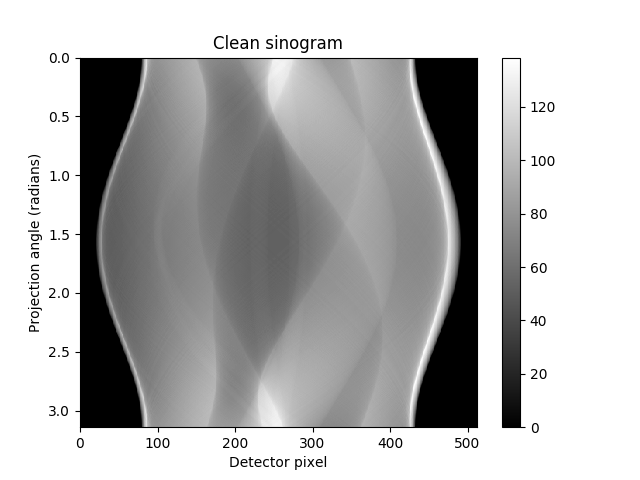

In [11]:
fig = plt.figure(2)
plt.imshow(sinogram,extent=[0,num_detector_pixels,np.pi,0],aspect='auto')
plt.title('Clean sinogram')
plt.colorbar()
plt.gray()
plt.xlabel('Detector pixel')
plt.ylabel('Projection angle (radians)')

We can simulate adding some noise to the sinogram as given by the flux parameter, where a higher flux means a better signal/less noise. If flux is set to infinite (np.inf) then no noise is added:

<IPython.core.display.Javascript object>


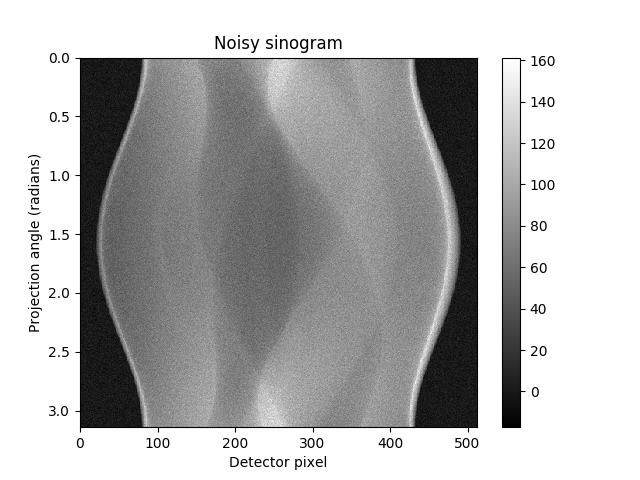

In [12]:
# Add noise
if ~np.isinf(flux):
    sinogram_noisy = astra.add_noise_to_sino(sinogram,flux) 
else:
    sinogram_noisy = sinogram

plt.figure(3)
plt.imshow(sinogram_noisy,extent=[0,num_detector_pixels,np.pi,0],aspect='auto')
plt.title('Noisy sinogram')
plt.colorbar()
plt.gray()
plt.xlabel('Detector pixel')
plt.ylabel('Projection angle (radians)')

From the clean and noisy sinogram we can compute filtered backprojection (FBP) reconstructions. We must specify whether to use the CPU or GPU and this should be chosen in agreement with what was chosen for the projector earlier.

The only other important parameter to be specified is which filter to use. 

Note that on the CPU, only the default 'ram-lak' is available, while on the GPU a range of filters are available:

In [13]:
# Choose either:
#rec_type = 'FBP'  # For CPU
rec_type = 'FBP_CUDA'  # For GPU

# Set filter for FBP - only works on GPU. Possible values:
# none, ram-lak, shepp-logan, cosine, hamming, hann, tukey, lanczos,
# triangular, gaussian, barlett-hann, blackman, nuttall, blackman-harris,
# blackman-nuttall, flat-top, kaiser, parzen
filter_type = 'ram-lak'

# Compute reconstructions
rec_id, rec = astra.create_reconstruction(rec_type, proj_id, sinogram, filterType=filter_type)
rec_noisy_id, rec_noisy = astra.create_reconstruction(rec_type, proj_id, sinogram_noisy, filterType=filter_type)

Display the two reconstructions:

<IPython.core.display.Javascript object>


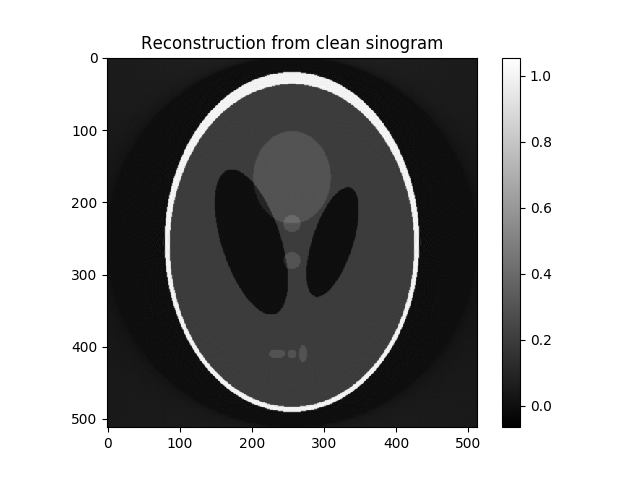

<IPython.core.display.Javascript object>


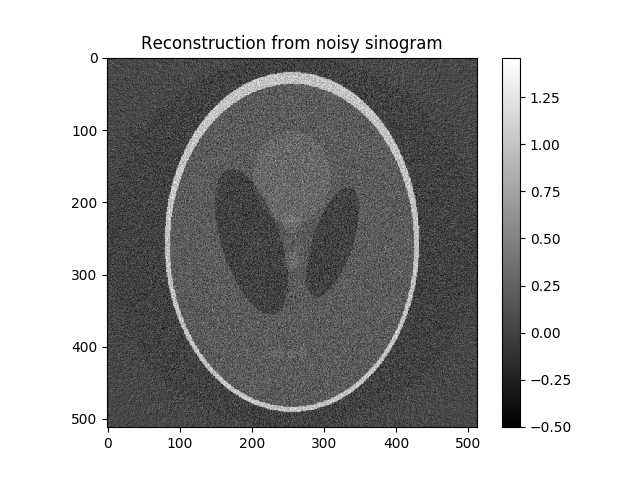

In [14]:
plt.figure(4)
plt.imshow(rec)
plt.title('Reconstruction from clean sinogram')
plt.colorbar()
plt.gray()

plt.figure(5)
plt.imshow(rec_noisy)
plt.title('Reconstruction from noisy sinogram')
plt.colorbar()
plt.gray()

Finally clean up (clear the ASTRA objects to prevent accumulation and eventually running out of memory):

In [15]:
astra.data2d.delete(rec_id)
astra.data2d.delete(rec_noisy_id)
astra.data2d.delete(sino_id)
astra.projector.delete(proj_id)